# Federated PyTorch MNIST Tutorial

In [1]:
#Install dependencies if not already installed
!pip install torch torchvision ..

Processing /home/radionov/fork/openfl


  Created wheel for openfl: filename=openfl-1.5-py3-none-any.whl size=1339000 sha256=c9603f2a859f4e0dfda8206913c15df755af914b7f93618cbdebdd20921d215c
  Stored in directory: /tmp/pip-ephem-wheel-cache-_14639wo/wheels/ad/78/eb/c87d3fd9ebd84a4104cb86785533043194630de211eeccc174
Successfully built openfl
  Attempting uninstall: openfl
    Found existing installation: openfl 1.5
    Uninstalling openfl-1.5:
      Successfully uninstalled openfl-1.5
You should consider upgrading via the '/home/radionov/.envs/old_api_fixes/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import openfl.native as fx
from openfl.federated import FederatedModel,FederatedDataSet


After importing the required packages, the next step is setting up our openfl workspace. To do this, simply run the `fx.init()` command as follows:

In [3]:
#Setup default workspace, logging, etc.
fx.init('torch_cnn_mnist',log_level='METRIC', log_file='./spam_metric.log')

Creating Workspace Directories
Creating Workspace Templates

New workspace directory structure:
workspace
├── impl
│   ├── __init__.py
│   ├── pt_cnn_fetschallenge.py
│   ├── challenge_assigner.py
│   ├── ptmnist_inmemory.py
│   ├── __pycache__
│   │   ├── ptmnist_inmemory.cpython-36.pyc
│   │   ├── __init__.cpython-36.pyc
│   │   ├── mnist_utils.cpython-36.pyc
│   │   ├── challenge_assigner.cpython-36.pyc
│   │   └── pt_cnn_fetschallenge.cpython-36.pyc
│   └── mnist_utils.py
├── agg__2021-05-19 10:25:59.267948.metric
├── .workspace
├── two__2021-05-19 10:25:59.271813.metric
├── data
│   ├── MICCAI_BraTS2020_TrainingData
│   │   ├── BraTS20_Training_210
│   │   ├── BraTS20_Training_023
│   │   ├── BraTS20_Training_101
│   │   ├── BraTS20_Training_227
│   │   ├── BraTS20_Training_097
│   │   ├── BraTS20_Training_046
│   │   ├── BraTS20_Training_038
│   │   ├── BraTS20_Training_296
│   │   ├── BraTS20_Training_302
│   │   ├── BraTS20_Training_211
│   │   ├── BraTS20_Training_040
│   │   

│   │   ├── BraTS20_Training_064
│   │   ├── BraTS20_Training_180
│   │   ├── BraTS20_Training_261
│   │   ├── BraTS20_Training_207
│   │   ├── BraTS20_Training_055
│   │   ├── BraTS20_Training_368
│   │   ├── BraTS20_Training_047
│   │   ├── BraTS20_Training_070
│   │   ├── BraTS20_Training_369
│   │   ├── BraTS20_Training_133
│   │   ├── BraTS20_Training_062
│   │   ├── BraTS20_Training_201
│   │   ├── BraTS20_Training_228
│   │   ├── BraTS20_Training_295
│   │   ├── BraTS20_Training_214
│   │   ├── BraTS20_Training_122
│   │   ├── BraTS20_Training_030
│   │   ├── BraTS20_Training_320
│   │   ├── BraTS20_Training_222
│   │   ├── BraTS20_Training_304
│   │   ├── BraTS20_Training_103
│   │   ├── BraTS20_Training_032
│   │   ├── BraTS20_Training_330
│   │   ├── BraTS20_Training_060
│   │   ├── BraTS20_Training_276
│   │   ├── BraTS20_Training_364
│   │   ├── BraTS20_Training_029
│   │   ├── BraTS20_Training_034
│   │   ├── BraTS20_Training_166
│   │   ├── BraTS20_Training_205
│   │   ├─

│   │   ├── n02791270
│   │   ├── n04275548
│   │   ├── n01917289
│   │   ├── n01910747
│   │   ├── n07768694
│   │   ├── n03255030
│   │   ├── n04532670
│   │   ├── n04259630
│   │   ├── n02279972
│   │   ├── n02480495
│   │   ├── n03250847
│   │   ├── n03770439
│   │   ├── n04118538
│   │   ├── n03891332
│   │   ├── n04356056
│   │   ├── n04465501
│   │   ├── n04070727
│   │   ├── n12267677
│   │   ├── n03160309
│   │   ├── n02481823
│   │   ├── n04560804
│   │   ├── n04501370
│   │   ├── n02666196
│   │   ├── n03404251
│   │   ├── n01641577
│   │   ├── n03649909
│   │   ├── n03584254
│   │   ├── n02056570
│   │   ├── n02808440
│   │   ├── n02058221
│   │   ├── n04596742
│   │   ├── n02395406
│   │   ├── n02948072
│   │   ├── n02268443
│   │   ├── n02669723
│   │   ├── n02423022
│   │   ├── n07695742
│   │   ├── n03937543
│   │   ├── n03980874
│   │   ├── n01983481
│   │   ├── n07734744
│   │   ├── n02795169
│   │   ├── n02129165
│   │   ├── n04311004
│   │   ├── n04562935
│   │   ├─

Now we are ready to define our dataset and model to perform federated learning on. The dataset should be composed of a numpy arrayWe start with a simple fully connected model that is trained on the MNIST dataset. 

In [4]:
def one_hot(labels, classes):
    return np.eye(classes)[labels]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

train_images,train_labels = trainset.train_data, np.array(trainset.train_labels)
train_images = torch.from_numpy(np.expand_dims(train_images, axis=1)).float()

validset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

valid_images,valid_labels = validset.test_data, np.array(validset.test_labels)
valid_images = torch.from_numpy(np.expand_dims(valid_images, axis=1)).float()
valid_labels = one_hot(valid_labels,10)

/home/radionov/.envs/old_api_fixes/lib/python3.6/site-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/radionov/.envs/old_api_fixes/lib/python3.6/site-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/radionov/.envs/old_api_fixes/lib/python3.6/site-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/radionov/.envs/old_api_fixes/lib/python3.6/site-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
feature_shape = train_images.shape[1]
classes       = 10

fl_data = FederatedDataSet(train_images,train_labels,valid_images,valid_labels,batch_size=32,num_classes=classes)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
optimizer = lambda x: optim.Adam(x, lr=1e-4)

def cross_entropy(output, target):
    """Binary cross-entropy metric
    """
    return F.cross_entropy(input=output,target=target)

In [6]:

#Create a federated model using the pytorch class, lambda optimizer function, and loss function
fl_model = FederatedModel(build_model=Net,optimizer=optimizer,loss_fn=cross_entropy,data_loader=fl_data)

The `FederatedModel` object is a wrapper around your Keras, Tensorflow or PyTorch model that makes it compatible with openfl. It provides built in federated training and validation functions that we will see used below. Using it's `setup` function, collaborator models and datasets can be automatically defined for the experiment. 

In [7]:
collaborator_models = fl_model.setup(num_collaborators=2)
collaborators = {'one':collaborator_models[0],'two':collaborator_models[1]}#, 'three':collaborator_models[2]}

In [8]:
#Original MNIST dataset
print(f'Original training data size: {len(train_images)}')
print(f'Original validation data size: {len(valid_images)}\n')

#Collaborator one's data
print(f'Collaborator one\'s training data size: {len(collaborator_models[0].data_loader.X_train)}')
print(f'Collaborator one\'s validation data size: {len(collaborator_models[0].data_loader.X_valid)}\n')

#Collaborator two's data
print(f'Collaborator two\'s training data size: {len(collaborator_models[1].data_loader.X_train)}')
print(f'Collaborator two\'s validation data size: {len(collaborator_models[1].data_loader.X_valid)}\n')

#Collaborator three's data
#print(f'Collaborator three\'s training data size: {len(collaborator_models[2].data_loader.X_train)}')
#print(f'Collaborator three\'s validation data size: {len(collaborator_models[2].data_loader.X_valid)}')

Original training data size: 60000
Original validation data size: 10000

Collaborator one's training data size: 30000
Collaborator one's validation data size: 5000

Collaborator two's training data size: 30000
Collaborator two's validation data size: 5000



We can see the current plan values by running the `fx.get_plan()` function

In [9]:
 #Get the current values of the plan. Each of these can be overridden
print(fx.get_plan())

{
    "aggregator.settings.best_state_path": "save/torch_cnn_mnist_best.pbuf",
    "aggregator.settings.db_store_rounds": 1,
    "aggregator.settings.init_state_path": "save/torch_cnn_mnist_init.pbuf",
    "aggregator.settings.last_state_path": "save/torch_cnn_mnist_last.pbuf",
    "aggregator.settings.metric_log": true,
    "aggregator.settings.rounds_to_train": 10,
    "aggregator.settings.tensor_board": true,
    "aggregator.template": "openfl.component.Aggregator",
    "assigner.settings.task_groups": [
        {
            "name": "train_and_validate",
            "percentage": 1.0,
            "tasks": [
                "aggregated_model_validation",
                "train",
                "locally_tuned_model_validation"
            ]
        }
    ],
    "assigner.template": "openfl.component.RandomGroupedAssigner",
    "collaborator.settings.db_store_rounds": 1,
    "collaborator.settings.delta_updates": false,
    "collaborator.settings.opt_treatment": "RESET",
    "collabo

Now we are ready to run our experiment. If we want to pass in custom plan settings, we can easily do that with the `override_config` parameter

In [10]:
#Run experiment, return trained FederatedModel
final_fl_model = fx.run_experiment(collaborators,{'aggregator.settings.rounds_to_train':10})

/home/radionov/.envs/old_api_fixes/lib/python3.6/site-packages/openfl/federated/task/runner_pt.py:276: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  new_state[k] = pt.from_numpy(tensor_dict.pop(k)).to(device)
/home/radionov/.envs/old_api_fixes/lib/python3.6/site-packages/openfl/federated/task/runner_pt.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


/home/radionov/.envs/old_api_fixes/lib/python3.6/site-packages/openfl/federated/task/runner_pt.py:452: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


<Figure size 1152x432 with 0 Axes>

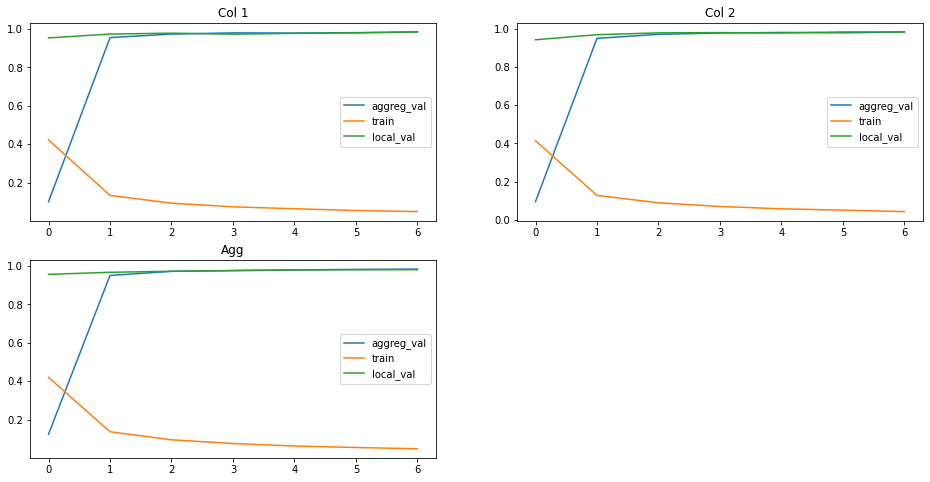

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys
from collections import defaultdict
import glob

factory = lambda : defaultdict(dict)
rounds = defaultdict(factory)
    
for begin in ['agg','one', 'two']:
    file = sorted(glob.glob(begin + '*.metric'))[-1]
    with open(file) as f:
        lines = f.readlines()
    if begin != 'agg':
        for line in lines:
            line = line.split()
            col_name = line[1]
            task = line[2]
            round = int(line[4])
            metric = float(line[6])
            assert(col_name == begin)
            rounds[round][col_name][task] = metric
    else:
        for line in lines:
            line = line.split()
            if len(line) < 6:
                continue
            task = line[0]
            round = int(line[5])
            metric = float(line[3])
            rounds[round]['agg'][task] = metric
            
def plot_collaborators_dict(rounds, agg=False):
    conf = 120
    figure(figsize=(16, 6))
    if agg:
        conf = 220
        figure(figsize=(16, 8))
    aggregated1 = []
    train1 = []
    local1 = []
    for round in rounds.keys():
        try:
            aggregated1.append(rounds[round]['one']['aggregated_model_validation'])
            train1.append(rounds[round]['one']['train'])
            local1.append(rounds[round]['one']['locally_tuned_model_validation'])
        except KeyError as e:
            print('Key error',e, 'round', round)
        
    
    ax1 = plt.subplot(conf+1)
    ax1.plot(aggregated1, label='aggreg_val')
    ax1.plot(train1, label='train')
    ax1.plot(local1, label='local_val')
    ax1.legend()
    ax1.set_title('Col 1')

    aggregated2 = []
    train2 = []
    local2 = []
    for round in rounds.keys():
        try:
            aggregated2.append(rounds[round]['two']['aggregated_model_validation'])
            train2.append(rounds[round]['two']['train'])
            local2.append(rounds[round]['two']['locally_tuned_model_validation'])
        except KeyError as e:
            print('Key error',e, 'round', round)
    ax2 = plt.subplot(conf+2)
    ax2.plot(aggregated2, label='aggreg_val')
    ax2.plot(train2, label='train')
    ax2.plot(local2, label='local_val')
    ax2.legend()
    ax2.set_title('Col 2')
    if agg:
        aggregated3 = []
        train3 = []
        local3 = []
        for round in rounds.keys():
            try:
                aggregated3.append(rounds[round]['agg']['aggregated_model_validation'])
                train3.append(rounds[round]['agg']['train'])
                local3.append(rounds[round]['agg']['locally_tuned_model_validation'])
            except KeyError as e:
                print('Key error',e, 'round', round)
        ax3 = plt.subplot(conf+3)
        ax3.plot(aggregated3, label='aggreg_val')
        ax3.plot(train3, label='train')
        ax3.plot(local3, label='local_val')
        ax3.legend()
        ax3.set_title('Agg')
plot_collaborators_dict(rounds,True)

In [12]:
#Save final model
final_fl_model.save_native('final_pytorch_model')

In [13]:
%reload_ext tensorboard